<a href="https://colab.research.google.com/github/Ali-Khatib/Comparative-Sentiment-Analysis-Across-varying-datasets/blob/amazon-customer-service-reviews/amazon_customer_reviews_polarity_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import nltk
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb
import warnings
import re
import os
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from collections import Counter
from nltk.util import ngrams




from textblob import TextBlob
warnings.filterwarnings("ignore")
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, logging
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import MultinomialNB


warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#nltk.down
#load('punkt_tab')
#nltk.download('averaged_perceptron_tagger_eng')
#nltk.download('all')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

lemmatizer = WordNetLemmatizer()

print("Imports are ready")

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/amazon-customerreviews-polarity/train.csv
/kaggle/input/amazon-customerreviews-polarity/test.csv
Imports are ready


In [ ]:
nltk.data.path.append('/usr/share/nltk_data/')
nltk.data.path.append('/kaggle/input/nltkdata/')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

print("nofalse")

nofalse


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
train_path = "/kaggle/input/amazon-customerreviews-polarity/train.csv"
test_path = "/kaggle/input/amazon-customerreviews-polarity/test.csv"

with open(train_path, 'r', encoding='utf-8') as f:
    train_lines = f.readlines()

with open(test_path, 'r', encoding='utf-8') as f:
    test_lines = f.readlines()


all_data = train_lines + test_lines


with open("merged_dataset.txt", "w", encoding='utf-8') as f:
    f.writelines(all_data)

print(" train and test datasets have been merged!")
print(f"Total lines in merged dataset: {len(all_data)}")

 train and test datasets have been merged!
Total lines in merged dataset: 4000000


In [ ]:
merged_path = "merged_dataset.txt"

with open(merged_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()


def parse_line(line):
    line = line.strip()
    if not line:
        return None, None


    if ',' in line:
        parts = line.split(',', 1)
        if len(parts) == 2:
            try:
                label = int(parts[0].strip().strip('"'))
                text = parts[1].strip().strip('"')
                return label, text
            except ValueError:
                pass


    match = re.match(r'^(\d+)\s+(.+)$', line)
    if match:
        return int(match.group(1)), match.group(2).strip()

    return None, None


data = [parse_line(line) for line in lines]
df = pd.DataFrame(data, columns=["label", "text"])


df_clean = df.dropna()


print(" DataFrame created successfully!")
print(f"Total rows parsed: {len(df)}")
print(f"Valid rows after removing None: {len(df_clean)}\n")
print(df_clean.head(10))
print("\n📊 Data types:")
print(df_clean.dtypes)
print(f"\nLabel distribution:\n{df_clean['label'].value_counts()}")

 DataFrame created successfully!
Total rows parsed: 4000000
Valid rows after removing None: 4000000

   label                                               text
0      2  Stuning even for the non-gamer","This sound tr...
1      2  The best soundtrack ever to anything.","I'm re...
2      2  Amazing!","This soundtrack is my favorite musi...
3      2  Excellent Soundtrack","I truly like this sound...
4      2  Remember, Pull Your Jaw Off The Floor After He...
5      2  an absolute masterpiece","I am quite sure any ...
6      1  Buyer beware","This is a self-published book, ...
7      2  Glorious story","I loved Whisper of the wicked...
8      2  A FIVE STAR BOOK","I just finished reading Whi...
9      2  Whispers of the Wicked Saints","This was a eas...

📊 Data types:
label     int64
text     object
dtype: object

Label distribution:
label
2    2000000
1    2000000
Name: count, dtype: int64


In [ ]:
df_clean=df.dropna().drop_duplicates()

df_clean.dtypes
df_clean['clean_text'] = df_clean['text'].str.lower()
df_clean['clean_text'] = df_clean['clean_text'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
df_clean['clean_text'] = df_clean['clean_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [ ]:
df_sample = df_clean.sample(n=500000, random_state=42)

df_sample['id']=df_sample.index
df_sample.dtypes

label          int64
text          object
clean_text    object
id             int64
dtype: object

In [ ]:
print(df_clean.columns.tolist())

In [ ]:
print("📈 DATASET OVERVIEW")
print("#" * 60)
print(f"Shape: {df_clean.shape}")
print(f"Columns: {df_clean.columns.tolist()}")
print(f"Sentiment distribution:\n{df_clean['label'].value_counts()}")

📈 DATASET OVERVIEW
############################################################
Shape: (3999999, 2)
Columns: ['label', 'clean_text']
Sentiment distribution:
label
2    2000000
1    1999999
Name: count, dtype: int64


In [ ]:

df_sample['text_length'] = df_sample['clean_text'].str.len()

df_sample['num_words'] = df_sample['clean_text'].str.split().apply(len)

df_sample.info

<bound method DataFrame.info of          label                                               text  \
1031451      2  Great for beginners!","I purchased this dvd af...   
214510       2  insight into the philosophy of libertarian soc...   
2145763      2  Works just like it says","I painted a cabinet ...   
2840775      1  typical excerpt:","bla-bla, there's standard c...   
2875450      2  Best Off Road Game EVER!!!","This game is the ...   
...        ...                                                ...   
3944280      2  This book is amazingly honest, thoughtful, and...   
2977704      2  great sounding speakers","These speakers sound...   
421343       1  Couldnt stay awake","Sorry...I've tried to wat...   
2362312      2  will not disappoint","I am writting this for p...   
914333       2  Aqua Teen Hunger Force Assemble!","Ok, I suppo...   

                                                clean_text       id  \
1031451  great for beginnersi purchased this dvd after ...  1031451 

In [ ]:

plt.figure(figsize=(8,4))
sb.histplot(df_sample['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Review Length (Characters) - Sample')
plt.xlabel('Number of Characters')
plt.ylabel('Count')
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
sb.histplot(df_sample['num_words'], bins=50, kde=True, color='orange')
plt.title('Distribution of Review Length (Words) - Sample')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
sb.boxplot(x='label', y='num_words', data=df_sample)
plt.xticks([0,1], ['Negative', 'Positive'])
plt.title('Review Length by Sentiment (Words) - Sample')
plt.ylabel('Number of Words')
plt.show()

In [ ]:


text = " ".join(df_sample['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews - Sample')
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
sb.histplot(data=df_sample, x='num_words', hue='label', bins=50, kde=True, palette=['red','green'])
plt.title('Review Length Distribution by Sentiment')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

In [ ]:
ax=df_sample['label'].value_counts().sort_index().plot(
    kind='bar',
    title='Number of reviews by score',
    figsize=(10, 6),
    color=sns.color_palette('BuGn'))

ax.set_xlabel('label')
plt.show()


sia=SentimentIntensityAnalyzer()


results={}
for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    clean_text=row['clean_text']
    id=row['id']
    results[id]=sia.polarity_scores(clean_text)

vaders=pd.DataFrame(results).T
vaders=vaders.merge(df_sample, left_index=True, right_on='id')
print(vaders.head())

fig, axs=plt.subplots(1,3, figsize=(15, 5))
sns.barplot(x='label', y='neg', data=vaders, ax=axs[0])
sns.barplot(x='label', y='neu', data=vaders, ax=axs[1])
sns.barplot(x='label', y='pos', data=vaders, ax=axs[2])

axs[0].set_title('Negative Sentiment')
axs[1].set_title('Neutral Sentiment')
axs[2].set_title('Positive Sentiment')

#Display the average compound sentiment for each score

plt.figure(figsize=(6, 4))
sns.barplot(x='label', y='compound', data=vaders)
plt.title('Vader Average Sentiment by Score')
plt.show()

def vader_label(compound): #Vader doesnt give a name , it gives a number, we want to map it on our own
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

vaders["predicted_sentiment"] = vaders["compound"].apply(vader_label)

def map_score_to_sentiment(label):
    if label <= 2:
        return "negative"
    elif label == 3:
        return "neutral"
    else:
        return "positive"

vaders["true_sentiment"] = vaders["label"].apply(map_score_to_sentiment)

cm = confusion_matrix(
    vaders["true_sentiment"],
    vaders["predicted_sentiment"],
    labels=["negative", "neutral", "positive"]
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])

disp.plot(cmap="Greens", values_format="d")
plt.title("VADER vs True Ratings (Confusion Matrix)")
plt.show()

⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.
Fetching 11 files: 100%|██████████████████████| 11/11 [00:00<00:00, 1953.15it/s]
/kaggle/working/roberta_local


Some weights of the model checkpoint at ./roberta_local were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
100%|██████████| 157/157 [04:07<00:00,  1.57s/it]


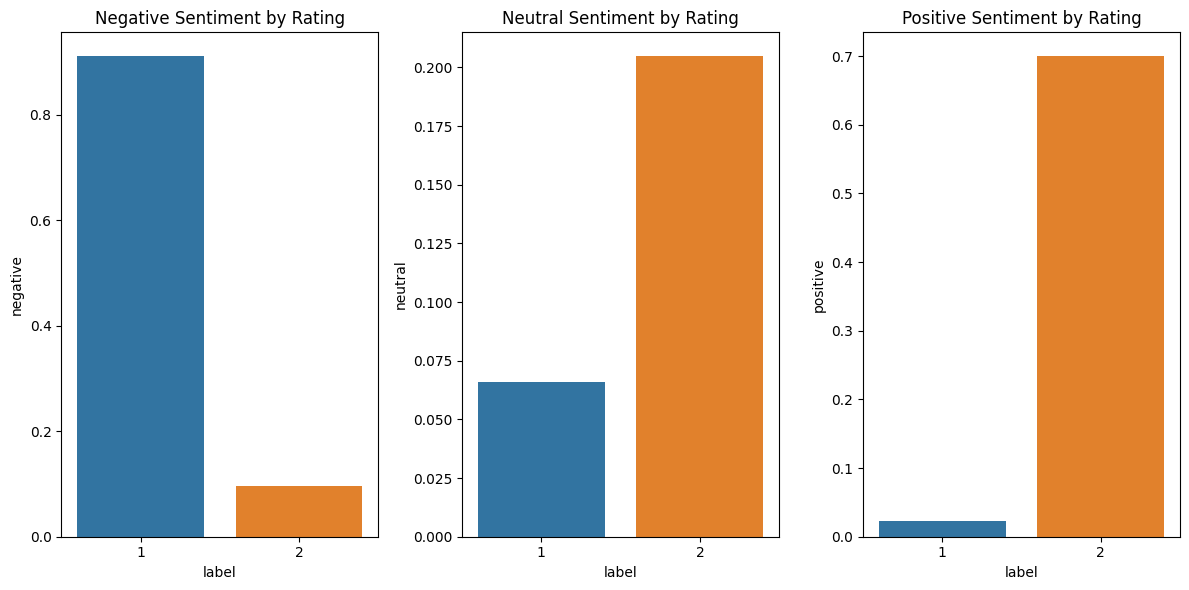

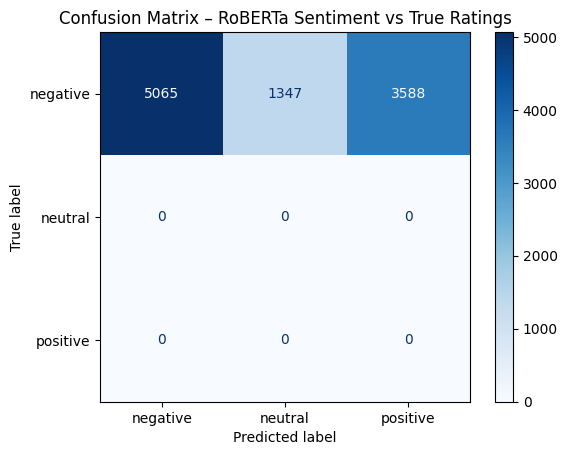

In [ ]:

!huggingface-cli download j-hartmann/sentiment-roberta-large-english-3-classes \
    --local-dir ./roberta_local \
    --repo-type model --resume-download

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch


MODEL_DIR = "./roberta_local"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR, local_files_only=True)

device = 0 if torch.cuda.is_available() else -1

classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=device,
    return_all_scores=False
)


subset = df_sample.head(10000).copy()

texts = subset['clean_text'].str.slice(0, 500).tolist()

batch_size = 64
sentiments = []

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    preds = classifier(batch)
    sentiments.extend([p['label'] for p in preds])

subset['sentiment'] = sentiments
subset[['id', 'clean_text', 'sentiment']].head()


bertas = (
    subset.groupby("label")["sentiment"]
          .value_counts(normalize=True)
          .unstack()
          .fillna(0)
)

bertas = bertas[['negative', 'neutral', 'positive']].reset_index()


fig, axs = plt.subplots(1,3, figsize=(12,6))

sns.barplot(x='label', y='negative', data=bertas, ax=axs[0])
sns.barplot(x='label', y='neutral', data=bertas, ax=axs[1])
sns.barplot(x='label', y='positive', data=bertas, ax=axs[2])

axs[0].set_title('Negative Sentiment by Rating')
axs[1].set_title('Neutral Sentiment by Rating')
axs[2].set_title('Positive Sentiment by Rating')

plt.tight_layout()
plt.show()



def map_score_to_sentiment(score):
    if score <= 2:
        return "negative"
    elif score == 3:
        return "neutral"
    else:
        return "positive"

subset["true_sentiment"] = subset["label"].apply(map_score_to_sentiment)



cm = confusion_matrix(
    subset["true_sentiment"],
    subset["sentiment"],
    labels=["negative", "neutral", "positive"]
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["negative", "neutral", "positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – RoBERTa Sentiment vs True Ratings")
plt.show()


In [ ]:

pattern=r"[a-zA-Z]+"

vect=TfidfVectorizer(
    token_pattern=pattern,
    stop_words='english',
    ngram_range=(1,2),
    max_features=500
)

vect.fit(df_sample["clean_text"])

tokenized_features=vect.transform(df_sample["clean_text"])

features=pd.DataFrame(data=tokenized_features.toarray(),
                     columns=vect.get_feature_names_out()
                     )


X = vect.transform(df_sample["clean_text"])
y = df_sample["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])



KeyboardInterrupt: 

In [ ]:
log_reg = LogisticRegression(max_iter= 1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted as")
plt.ylabel("True-Actually is")
plt.show()

In [ ]:

nb_classifier=MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb =nb_classifier.predict(X_test)

cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6, 5))
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb_classifier.classes_)
disp_nb.plot(cmap='Purples', values_format='d', ax=plt.gca())

plt.title("Confusion Matrix - Naive Bayes Model", fontsize=14)
plt.show()

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_sample['clean_text'])

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print("Vocab size:", vocab_size)

max_len = 200
sequences = tokenizer.texts_to_sequences(df_sample['clean_text'])
X_padded = pad_sequences(sequences, maxlen=max_len, padding="post")

embedding_dim = 100
glove_path = "/kaggle/input/glove6b100dtxt/glove.6B.100d.txt"

embeddings_index = {}

with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector

print("Loaded word vectors:", len(embeddings_index))

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector


X = X_padded
y = df_sample["label"].values

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Vocab size: 687768
Loaded word vectors: 400000
Train shape: (400000, 200)
Test shape: (100000, 200)


In [ ]:
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False  # USE GloVe!
    ),

    Conv1D(256, 5, activation='relu'),
    MaxPooling1D(2),

    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),

    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(1e-3),
    metrics=["accuracy"]
)

I0000 00:00:1765133772.423614      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11176 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765133772.424305      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=6,
    batch_size=128,
    verbose=1
)


Epoch 1/6


I0000 00:00:1765133783.231199     163 service.cc:148] XLA service 0x7cd74c004dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765133783.231978     163 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765133783.231996     163 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765133783.560455     163 cuda_dnn.cc:529] Loaded cuDNN version 90300


  16/2813 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.4345 - loss: -15.2033

I0000 00:00:1765133788.849946     163 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.4971 - loss: -33022162944.0000 - val_accuracy: 0.5000 - val_loss: -713749561344.0000
Epoch 2/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.4999 - loss: -1733891457024.0000 - val_accuracy: 0.5000 - val_loss: -7303578255360.0000
Epoch 3/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.5005 - loss: -11107549839360.0000 - val_accuracy: 0.5000 - val_loss: -27354430701568.0000
Epoch 4/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.5001 - loss: -36138433642496.0000 - val_accuracy: 0.5000 - val_loss: -69976954241024.0000
Epoch 5/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.5015 - loss: -86075238252544.0000 - val_accuracy: 0.5000 - val_loss: -145856602832896.0000
Epoch 6/6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.4991 - loss: -172866192539648.0000 - val_accuracy: 0.5000 - val_loss: -267351714955264.0000


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           1       0.50      1.00      0.67     50016
           2       0.00      0.00      0.00     49984

    accuracy                           0.50    100000
   macro avg       0.25      0.50      0.33    100000
weighted avg       0.25      0.50      0.33    100000



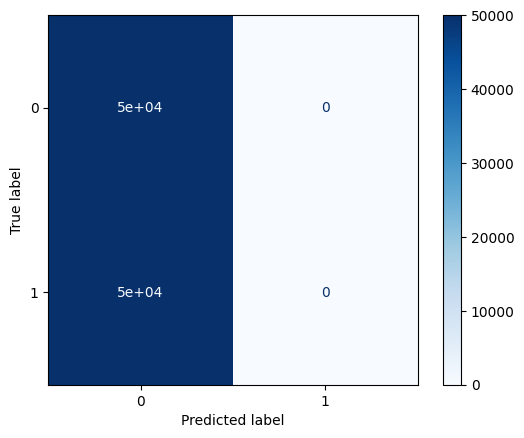

In [ ]:
y_pred_probs = model.predict(X_test).ravel()

y_pred = (y_pred_probs >= 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.show()